In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Deconv2D(nn.Module):
    def __init__(self, shape=(2, 4)):
        super(Deconv2D, self).__init__()
        self.w_flat = nn.Parameter(data=torch.zeros(shape[0]*shape[1]-1),
                                   requires_grad=True)
        self.h_shape = shape

    def forward(self, x):
        w = nn.functional.pad(self.w_flat, (1, 0), value=1)

        w = torch.reshape(w, self.h_shape)
        hm1 = nn.functional.pad(w, (0, x.size(-1)-w.size(-1), 0, x.size(-2)-w.size(-2)))

        gm1f = 1/fft2(hm1)

        gm2f = torch.flip(gm1f, (0,))
        gm2f = torch.roll(gm1f, shifts=1, dims=0)

        gm3f = torch.flip(gm1f, (1,))
        gm3f = torch.roll(gm1f, shifts=1, dims=1)

        gm4f = torch.flip(gm1f, (0, 1))
        gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

        gmf = gm1f*gm2f*gm3f*gm4f

        ymf = gmf*fft2(x)

        y = ifft2(ymf).real

        return y

In [ ]:
def blur_images(img, w=torch.FloatTensor([[1, 0.2, 0, 0], [0, 0, 0, 0]])):

    # 4 factor blur

    hm1 = nn.functional.pad(w, (0, img.size(-1)-w.size(-1), 0, img.size(-2)-w.size(-2)))

    gm1f = fft2(hm1)

    gm2f = torch.flip(gm1f, (0,))
    gm2f = torch.roll(gm1f, shifts=1, dims=0)

    gm3f = torch.flip(gm1f, (1,))
    gm3f = torch.roll(gm1f, shifts=1, dims=1)

    gm4f = torch.flip(gm1f, (0, 1))
    gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

    gmf = gm1f*gm2f*gm3f*gm4f

    ymf = gmf*fft2(img)

    X = ifft2(ymf).real

    return X

In [ ]:
def gaussian_kernel(size, sigma=1):
    assert size % 2 == 1
    kernel = np.zeros((size, size))
    center = size // 2
    
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    kernel = kernel / kernel.sum()
    kernel = kernel[center:, center:]
    kernel[0, 0] = 1.0
    return kernel 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/blur-dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class GoproSynthetic(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        y_imgs = os.listdir(f'{ds_path}/sharp')

        self.y_paths = list(map(lambda img_path: f'{ds_path}/sharp/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        y_path = self.y_paths[idx]

        # x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)

        SIZE = 64
        PAD_SIZE = SIZE//2

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        blur_kernel = torch.FloatTensor(gaussian_kernel(29, 0.5))
        x_img = blur_images(y_img)

        return x_img, y_img

In [ ]:
data = GoproSynthetic(ds_path=base_path)

data_len = len(data)
dataloader = DataLoader(data, batch_size=16, shuffle=False)

data_len

350

(-0.5, 127.5, 127.5, -0.5)

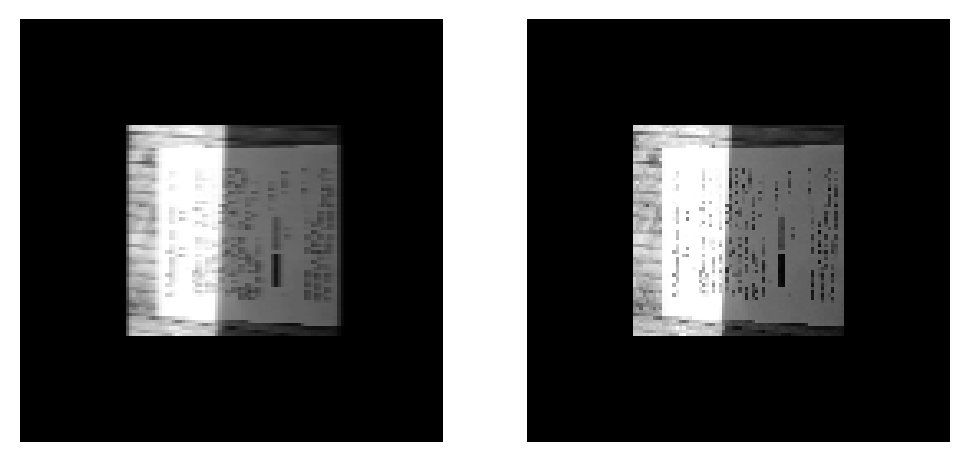

In [ ]:
blur_img, unblur_img = next(iter(dataloader))

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(blur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unblur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

In [ ]:
model = Deconv2D((20, 20))

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss= 0.0

        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = criterion(outputs, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss

        if (epoch+1)%10 == 0:
            print('Epoch {:04d} loss: {:.4f}'.format(epoch+1, running_loss))

In [ ]:
train_model(model, criterion, optimizer, dataloader, num_epochs=100)

Epoch 0010 loss: 0.0268
Epoch 0020 loss: 0.0115
Epoch 0030 loss: 0.0054
Epoch 0040 loss: 0.0025
Epoch 0050 loss: 0.0011
Epoch 0060 loss: 0.0004
Epoch 0070 loss: 0.0001
Epoch 0080 loss: 0.0000
Epoch 0090 loss: 0.0000
Epoch 0100 loss: 0.0000


In [ ]:
model.eval()
X, y = next(iter(dataloader))

X = X.to(device)
y = y.to(device)

y_pred = model(X)

In [ ]:
X = X.to("cpu")
y = y.to("cpu")
y_pred = y_pred.to("cpu")

Text(0.5, 1.0, 'Original')

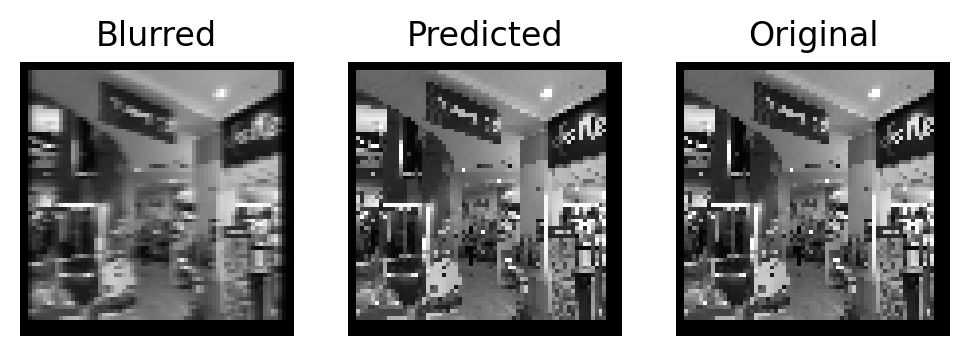

In [ ]:
import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,30:100,30:100], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,30:100,30:100].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,30:100,30:100], cmap='gray')
plt.axis('off')
plt.title('Original')

In [ ]:
model.w_flat

Parameter containing:
tensor([ 1.9904e-01,  6.3060e-04,  1.7618e-04, -2.2020e-05, -7.3599e-06,
         5.6836e-06,  6.5775e-06,  6.6101e-06,  4.2053e-06,  7.4452e-06,
         2.8890e-06, -3.9298e-06,  6.3560e-06,  1.2431e-06,  1.1928e-05,
        -6.6826e-06,  6.6648e-06,  3.7065e-07,  7.3432e-06,  1.5525e-04,
         8.4435e-04, -6.2497e-04, -1.7607e-04, -5.7701e-05, -4.2264e-06,
        -4.2214e-06, -1.0190e-05, -1.2443e-05, -1.6065e-06, -5.4301e-06,
        -1.1487e-05,  9.7010e-06, -6.9188e-06, -8.8846e-06, -1.4290e-05,
         1.0196e-05, -6.9345e-06, -4.0503e-06, -8.7922e-06, -1.4316e-04,
        -4.1068e-05,  2.4640e-06,  4.1050e-05,  7.8198e-05,  1.5586e-05,
         3.9493e-06,  9.6370e-06, -7.6225e-07,  1.1442e-06, -1.0876e-05,
         1.0092e-05, -2.5441e-06,  9.3900e-06,  6.8804e-06,  1.7076e-06,
        -7.8325e-06,  3.4123e-06,  9.5762e-06, -7.0714e-06,  9.8521e-06,
         6.3230e-06,  9.0731e-06, -6.5902e-06, -7.7514e-06,  4.7520e-06,
        -3.9335e-06, -1.5037e

In [ ]:
class GoProSmall(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        x_imgs = os.listdir(f'{ds_path}/blur')[:10]
        y_imgs = os.listdir(f'{ds_path}/sharp')[:10]

        self.x_paths = list(map(lambda img_path: f'{ds_path}/blur/{img_path}', x_imgs))
        self.y_paths = list(map(lambda img_path: f'{ds_path}/sharp/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.x_paths)


    def __getitem__(self, idx):
        x_path = self.x_paths[idx]
        y_path = self.y_paths[idx]

        x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)

        SIZE = 64
        PAD_SIZE = SIZE//2

        # Preprocess image
        x_img = T.Resize((SIZE, SIZE))(x_img)
        x_img = x_img / 255.0
        x_img = nn.functional.pad(x_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        return x_img, y_img